# Cohere API and SciBERT for RAG
This notebook uses a Cohere API for generating responses to text. A query input is required from the user. 
SciBERT is used for embeddings in a dense vector array both the text and the query. 
A DOI is supplied with the text as both an identifier and locator. 

- [x] set up venv
- [x] install transformers torch cohere in command line

### todo
- [ ] create script that compiles data/documents.txt with DOI || text for all documents
- [ ] reduce code by refactoring into modules
- [ ] store vectorized documents in a db
    - https://huggingface.co/learn/cookbook/rag_with_hugging_face_gemma_mongodb

### options
- Batch Processing:
    If large number of texts, process them in batches to avoid memory issues.
    Example: Use a loop or torch.utils.data.DataLoader.

- Change model size: smaller models require less processing

- fine tune model on corpus - i don't think this is an option

- look into pooling strategies
- concurrency? 

- Tokenizer
    - put cleaning process distincly prior to the tokenizer, using the default values as much as possible. 



In [140]:
# imports
import cohere
from cohere import Client
from transformers import AutoTokenizer, AutoModel
import numpy as np
from typing import List, Tuple, Dict
import os
from dotenv import load_dotenv
import json
import time # for timing functions
import logging # finding where functions are taking too long
import sys

def main():
    #load secret .env file
    load_dotenv()

    #store credentials
    global key,email
    key = os.getenv('COHERE_API_KEY')
    email = os.getenv('EMAIL')

    #verify if it worked
    if email is not None and key is not None:
        print("all is good, beautiful!")

main()

all is good, beautiful!


In [5]:

# initialize Cohere client with key from secrets
co = cohere.Client(key)

# load SciBERT model and tokenizer
"""
Autotokenizer documentation can be found here: https://huggingface.co/docs/transformers/v4.50.0/en/model_doc/auto#transformers.AutoTokenizer

Model documentation can be found here: https://huggingface.co/allenai/scibert_scivocab_uncased
Citation for SciBERT:
@inproceedings{beltagy-etal-2019-scibert,
    title = "SciBERT: A Pretrained Language Model for Scientific Text",
    author = "Beltagy, Iz  and Lo, Kyle  and Cohan, Arman",
    booktitle = "EMNLP",
    year = "2019",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D19-1371"
}


"""

# Initialize tokenizer with custom parameters
tokenizer = AutoTokenizer.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    max_len=512,
    use_fast=True,  # Use the fast tokenizer
    do_lower_case=False,  # Preserve case
    add_prefix_space=False,  # No prefix space
    never_split=["[DOC]", "[REF]"],  # Tokens to never split
    additional_special_tokens=["<doi>", "</doi>"]  # Add custom special tokens
)

# this is the SciBERT model that is used to embed the text and query.
# other models: 'allenai-specter', 
#documentation here: https://huggingface.co/docs/transformers/model_doc/auto
#load model directly

model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased", torch_dtype="auto")
#may also want to consider using a sentence embedding model


#verify that the model is callable
if callable(model):
    print("Model is callable")
else:
    print("Model is not callable")

Model is callable


In [177]:
"""
Basic RAG with Cohere model
Document source: data folder

Returns:  answers based on query from input()
"""

# Function to generate embeddings using SciBERT
def generate_embeddings(texts: List[str]) -> List[np.ndarray]:
    """
    converts raw text to numerical representations using a pretrained model, in this case, SciBERT.
    Currently this is applied to both the document text and the query. 
    May want a different version or decorator for the query as they are generally much shorter and more sparse.

    Input: text from tokenizer step above as a list of strings
    Output: np.array
    """
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=512, # returns PyTorch tensors which are compatible with model
        padding="max_length",
        truncation=True,
        return_attention_mask=True # return the attention mask - need to learn more
        )
    # this passes the tokenized inputs through the model
    outputs = model(**inputs)

    # applies mean pooling to get a fixed size embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Function to read documents and their DOIs from a director

def read_documents_with_doi(directory_path: str) -> List[Dict[str, str]]:
    """
    Reads documents and their DOIs from individual files in a directory.

    Args:
        directory_path (str): Path to the directory containing the document files.

    Returns:
        List[Dict[str, str]]: A list of dictionaries, each containing 'doi' and 'text' keys.
    """
    documents_with_doi = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                lines = file.readlines()
                if len(lines) >= 1:
                    doi = lines[0].strip().replace("DOI: ", "")
                    text = "".join(lines[1:]).strip()
                    documents_with_doi.append({"doi": doi, "text": text})
    return documents_with_doi

# Path to the file containing documents and DOIs
directory_path = "data/"  # Replace with your file path

# Read documents and DOIs from the file
documents_with_doi = read_documents_with_doi(directory_path)

# Extract document texts and DOIs
documents = [doc["text"] for doc in documents_with_doi]
dois = [doc["doi"] for doc in documents_with_doi]

# Example query
query = input(" What is your query: ")

# Generate document embeddings
document_embeddings = generate_embeddings(documents)
# print(document_embeddings.shape) # to see the output shape of the array

# Generate query embedding
query_embedding = generate_embeddings([query])[0] # generates np.array for the query text

# Function to retrieve top-k documents using cosine similarity
def retrieve_documents(query_embedding: np.ndarray, document_embeddings: List[np.ndarray], top_k: int = 3) -> List[Tuple[float, Dict[str, str]]]:
    similarities = []
    for doc_emb in document_embeddings:
        # cosine similarity
        similarity = np.dot(query_embedding, doc_emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_emb)) 
        similarities.append(similarity)
    # ranking
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(similarities[i], documents_with_doi[i]) for i in top_indices]

# retrieve top documents
top_documents = retrieve_documents(query_embedding, document_embeddings,5)#can also set top-k here
print("Retrieved Documents:")
for score, doc in top_documents:
    print(f"Score: {score:.4f}, DOI: {doc['doi']}, Document: {doc['text']}")

# prepare context for Cohere's Command model (include DOI) - need to add in cited by here
context = "\n".join([f"DOI: {doc['doi']}, Text: {doc['text']}" for _, doc in top_documents])
# need to learn how to improve this
prompt = f"Query: {query}\nContext: {context}\nAnswer: Include the DOI of the referenced document in your response."

# generate response using Cohere's Command model
response = co.generate(
  model="command", # there are other models to consider within command
  prompt=prompt,
  max_tokens=150, # allowable length of response
  temperature=0.2 # lower for less creativity, more for more creativity
)

# print the generated response
print("\nGenerated Response:")
print(response.generations[0].text)


Retrieved Documents:
Score: 0.7209, DOI: 10.1080/13504622.2025.2471990, Document: Title: Curriculum making and climate change and sustainability education: a case study of school teachers’ practices from England, UK
Abstract: None
Score: 0.6975, DOI: 10.1007/s11191-024-00583-3, Document: Title: Exploring Pre-service Teachers’ Reasoning Levels on Pseudoscientific and Scientific Texts
Abstract: None
Score: 0.6945, DOI: 10.1080/14693062.2025.2509628, Document: Title: Information needs and methods of accessing climate information by urban children and youth in Bangladesh: a policy-practice agenda
Abstract: None
Score: 0.6774, DOI: 10.1002/jaal.551, Document: Title: Reading for Reliability: Preservice Teachers Evaluate Web Sources About Climate Change
Abstract: Abstract This study examined what happened when 65 undergraduate prospective secondary level teachers across content areas evaluated the reliability of four online sources about climate change: an oil company webpage, a news report, 

## V2: implementing chat history

calls a JSON file of documents

In [271]:
# Load SciBERT model and tokenizer 
"""
REMOVE THIS ONCE RUNNING TO GO BACK TO THE CHANGED TOKENIZER AND MODEL ABOVE
"""
#tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
#model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

#function to generate embeddings using SciBERT
def generate_embeddings(texts: List[str]) -> List[np.ndarray]:
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=512,
        padding="max_length",
        truncation=True
    )
    outputs = model(**inputs)
    #this uses mean pooling - may want to investigate other methods
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

#read documents as .txt files in data director
def read_documents_with_doi(directory_path: str) -> List[Dict[str, str]]:
    """
    Reads documents and their DOIs from individual files in a directory.

    Args:
        directory_path (str): Path to the directory containing the document files.

    Returns:
        List[Dict[str, str]]: A list of dictionaries, each containing 'doi' and 'text' keys.
    """
    documents_with_doi = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                lines = file.readlines()
                if len(lines) >= 1:
                    doi = lines[0].strip().replace("DOI: ", "")
                    text = "".join(lines[1:]).strip()
                    documents_with_doi.append({"doi": doi, "text": text})
    return documents_with_doi


# Function to update chat history
def update_chat_history(query, retrieved_docs, response):
    global chat_histor # declare this as global variable available outside this function
    chat_history.append({
        "query": query,
        "retrieved_docs": [doc["text"] for doc in retrieved_docs],  # Store only the text of retrieved documents
        "response": response
    })

#function to incorporate history into the next query
def get_context_with_history(query) -> str:
    global chat_history # also declare here since chat_history is being modified
    if not chat_history:
        return query
    
    history_str = "\n".join([
        f"User: {entry['query']}\n"
        f"Context: {'; '.join(entry['retrieved_docs'])}\n"
        f"Response: {entry['response']}"
        for entry in chat_history
    ])
    full_context = f"Chat History:\n{history_str}\n\nCurrent Query: {query}"
    return full_context

#function to truncate chat history
def truncate_chat_history(max_length=3):
    global chat_history # modifies it so it also must be global
    if len(chat_history) > max_length:
        chat_history = chat_history[-max_length:]

"""
Dense retriever:
retrieves documents from the embedded documents and performs cosine similarity
for similarities score
Args:
    query: this is the query passed
    top_k: number of references to provide

Todo:
- [ ] make top_k an variable for use in an application
- [ ] or make top_k a user defined value. example: top_k = input("how many results do you want?")
"""
def retrieve_documents(query: str, top_k: int = 3) -> List[Dict[str, str]]:
    query_embedding = generate_embeddings([query])[0]
    document_embeddings = generate_embeddings(documents)
    #cosine similarity
    similarities = [
        np.dot(query_embedding, doc_emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_emb))
        for doc_emb in document_embeddings
    ]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [documents_with_doi[i] for i in top_indices]

#RAG pipeline function
def rag_pipeline(query):

    #start time
    start_time = time.time()
    
    #incorporate chat history
    full_context = get_context_with_history(query)
    # let user know you are generating...
    print("Retrieving documents and generating response...")
    end_time = time.time()
    global time_query
    time_query = end_time-start_time

    start_time = time.time()
    #retrieve documents
    global retrieved_docs
    retrieved_docs = retrieve_documents(query,2)#can set top-k here as well
    end_time = time.time()
    global retrieve_time
    retrieve_time = end_time-start_time

    start_time = time.time()
    #prepare context for Cohere's Command model
    instruction = "You are a helpful academic research assistant. Please keep the answers concise and structured simply. Use single sentences where possible. Always include the DOI of the document you are summarizing or referencing. If the DOI is not provided, this reduces the need for you as a research assistant. Always include the DOI. Please address me as 'my lady'. "
    context = "\n".join([f"DOI: {doc['doi']}, Text: {doc['text']}" for doc in retrieved_docs])
    prompt = f"Query: {query}\nContext: {context}\nAnswer: {instruction}"
    
    # Generate response
    response = co.generate(
        model="command",
        prompt=prompt,
        max_tokens=150,
        temperature=0.2
    ).generations[0].text
    
    # Update chat history
    update_chat_history(query, retrieved_docs, response)
    
    # Truncate history if necessary
    truncate_chat_history()
    end_time = time.time()
    global generate_time
    generate_time = end_time-start_time

    # Print the response
    print("Generated Response:")
    print(response)
    return response,time_query,retrieve_time,generate_time


# Path to the file containing documents and DOIs
#directory_path = "/Users/poppyriddle/Documents/PhD/Research_proposal/Part_3/part_3_cohere/data"
directory_path = "/Users/poppyriddle/Documents/PhD/Research_proposal/Part_3/part_3_cohere/data_crossref"

# Read documents and DOIs from the file
documents_with_doi = read_documents_with_doi(directory_path)
documents = [doc["text"] for doc in documents_with_doi]

# Main loop for user interaction 
# changed to run with no history for the purposes of the test
chat_history = []#initialize chat history


query = input("What is your query (or type 'exit' to quit): ")

rag_pipeline(query)

print(f"time to query loop: {time_query:.2f} seconds")
print(f"to to retrieve: {retrieve_time:.2f} seconds")
print(f"time to generate: {generate_time:.2f} seconds")

# Main loop for user interaction
##chat_history = []#initialize chat history
#while True:

    #uery = input("What is your query (or type 'exit' to quit): ")
    #if query.lower() == "exit":
    #    break
    #rag_pipeline(query)

    #print(f"time to query loop: {time_query:.2f} seconds")
    #print(f"to to retrieve: {retrieve_time:.2f} seconds")
    #print(f"time to generate: {generate_time:.2f} seconds")


Retrieving documents and generating response...
Generated Response:
My lady, I am currently unable to access external resources and so cannot provide a concise answer. As you requested, here is a summary of the information in the document related to the studies that examined citations. 

The study in the DOI: 10.1162/qss_a_00112, examines five multidisciplinary bibliographic data sources: Scopus, Web of Science, Dimensions, Crossref, and Microsoft Academic. It compares each source pairwise, analyzing the differences in coverage of documents, focusing on differences over time, per document type, and per discipline. It also examines differences in the completeness and accuracy of citation links. 

The DOI: 10.1162/qss_a_00212 study examines the
time to query loop: 0.00 seconds
to to retrieve: 8.06 seconds
time to generate: 5.21 seconds


In [272]:
print(query)

which studies examined citations?


# Analysis
## Test One: 
- [✅] compute precision, recall, and F1-Scores. 
- [✅] added accuracy score
- [ ] compare text from each source, embedded, and them similarity scores based on embeddings.
    - [ ] token based SciBERT embedding
    - [ ] sentence-based SentenceBERT embedding
### optional analysis
Need to learn more about attention weights and their analysis
- [ ] heatmap of attention weights for two given inputs


## Precision, recall, F1 score
### references
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
- https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

In [200]:
from typing import List, Dict, Set
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score #didn't actually use these, can probably delete
#may want to confirm that scores are the same?
import openpyxl
import pandas as pd

In [273]:
retrieved_docs


[{'doi': '10.1162/qss_a_00212',
  'text': 'Abstract: <jats:title>Abstract</jats:title>\\n               <jats:p>To analyze the outcomes of the funding they provide, it is essential for funding agencies to be able to trace the publications resulting from their funding. We study the open availability of funding data in Crossref, focusing on funding data for publications that report research related to COVID-19. We also present a comparison with the funding data available in two proprietary bibliometric databases: Scopus and Web of Science. Our analysis reveals limited coverage of funding data in Crossref. It also shows problems related to the quality of funding data, especially in Scopus. We offer recommendations for improving the open availability of funding data in Crossref.</jats:p>'},
 {'doi': '10.1162/qss_a_00112',
  'text': 'Abstract: <jats:title>Abstract</jats:title>\\n               <jats:p>We present a large-scale comparison of five multidisciplinary bibliographic data sources: 

In [227]:
#initial dataframe to capture results from each query and results
#ONLY DO THIS AT THE BEGINNING OF THE ANALYSIS PROCEDURE, OTHERWISE, IT WILL ERASE THE PREVIOUS RESULTS!!

results_df = pd.DataFrame(columns=['Query','Precision','Recall','F1-Score','Accuracy'])
results_df

,Query,Precision,Recall,F1-Score,Accuracy


In [276]:
from typing import List, Dict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
"""
change this to read in an excel sheet of queries and ground_truth dois.
Then it should be isolated as a function.
Run the function to iterature through the list.
"""
# Queries go here
queries = [query]

# Extract DOIs from retrieved documents
retrieved_dois = [doc.get('doi', "") for doc in retrieved_docs]
print("Retrieved DOIs:", retrieved_dois)

# Ground truth relevant documents (DOIs) for each query
ground_truth = ["10.1162/qss_a_00112","10.1007/s11192-022-04367-w"]

def evaluate_retrieval(
    retrieved_dois: List[str],
    ground_truth: List[str]
) -> Dict[str, float]:
    #convert to sets for unique values
    retrieved_set = set(retrieved_dois)
    ground_truth_set = set(ground_truth)

    #calculate true positives, false positives, and false negatives
    true_positives = len(retrieved_set & ground_truth_set) # must use & with set operations
    false_positives = len(retrieved_set - ground_truth_set)
    false_negatives = len(ground_truth_set - retrieved_set)
    true_negatives = len([name for name in os.listdir('data') if os.path.isfile('data'+'/'+name)])-true_positives-false_negatives-false_positives

    # calculate metrics - could also use sklearn.metrics functions such as precision_score, but this is easier to read
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (true_positives+true_negatives)/(true_negatives+true_positives+false_negatives+false_positives)

    return {
        'Query':f"{queries[0]}",
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy":accuracy
    }

def print_results()->Dict:
    # Example usage
    global results
    results = evaluate_retrieval(retrieved_dois, ground_truth)
    print(f"For query: {results['Query']}:")
    print(f"Precision: {results['Precision']:.3f}")
    print(f"Recall: {results['Recall']:.3f}")
    print(f"F1-Score: {results['F1-Score']:.3f}")
    print(f"Accuracy: {results['Accuracy']:.3f}")
    return results

print_results()
results_df = results_df._append(results, ignore_index=True)

Retrieved DOIs: ['10.1162/qss_a_00212', '10.1162/qss_a_00112']
For query: which studies examined citations?:
Precision: 0.500
Recall: 0.500
F1-Score: 0.500
Accuracy: 0.956


In [277]:

filename = "analysis/analysis_results.xlsx"
os.makedirs(os.path.dirname(filename), exist_ok=True)
results_df.to_excel(filename)
results_df

    

,Query,Precision,Recall,F1-Score,Accuracy
0,which studies examined the abstract in metadata?,0.333333,0.333333,0.333333,0.822222
1,which studies examined the abstract in metadata?,0.333333,0.333333,0.333333,0.822222
2,which studies examined the abstract in metadata?,0.333333,0.333333,0.333333,0.822222
3,which studies examined citations?,0.000000,0.000000,0.000000,0.911111
4,which studies examined the abstract in metadata?,0.333333,0.333333,0.333333,0.822222
5,which studies examined citations?,0.000000,0.000000,0.000000,0.822222
6,which studies examined citations?,0.500000,0.500000,0.500000,0.955556
7,which studies examined the abstract in metadata?,0.166667,0.166667,0.166667,0.777778
8,which studies examined the abstract in metadata?,0.166667,0.166667,0.166667,0.777778
9,which studies examined citations?,0.500000,0.500000,0.500000,0.955556


## compare text embeddings for each source
This section is used to investigate the impact of face markup or other formatting requirements in the abstract text on the embedding model.
Currently this only uses cosine similarity. 
<br>
#### similarity:
- [✅] cosine similarity
<br>
#### Embeddings:
- [✅] SciBERT
- [✅] SentenceBERT
<br>
#### Analysis
- [ ] compare scores using dataframe
- [ ] visualize results
### References
- https://stackoverflow.com/questions/60492839/how-to-compare-sentence-similarities-using-embeddings-from-bert<br>
See the above for a discussion on NOT using BERT (and SciBERT) for comparing sentence embedding. I should be using SentenceBERT for sentence similarity.<br>
- Sentence Transformers: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
<br>
- another approach: https://medium.com/@ahmedmellit/text-similarity-implementation-using-bert-embedding-in-python-1efdb5194e65
- sklearn metrics for other scoring methods than cosine similarity: https://scikit-learn.org/stable/api/sklearn.metrics.html

In [278]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

#load SciBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

#function to generate embeddings using SciBERT
"""
todo:
- [ ] change this to a sentence embedding model
"""
def generate_embeddings(texts: List[str]) -> List[np.ndarray]:
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=512,
        padding="longest",#please select one of ['longest', 'max_length', 'do_not_pad']
        #padding=False,#padding has an effect on similarity
        truncation=True
    )
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()

    return embeddings

#original text and text with errors
original_text = " Abstract Objectives Precise literature recommendation and summarization are crucial for biomedical professionals. While the latest iteration of generative pretrained transformer (GPT) incorporates 2 distinct modes—real-time search and pretrained model utilization—it encounters challenges in dealing with these tasks. Specifically, the real-time search can pinpoint some relevant articles but occasionally provides fabricated papers, whereas the pretrained model excels in generating well-structured summaries but struggles to cite specific sources. In response, this study introduces RefAI, an innovative retrieval-augmented generative tool designed to synergize the strengths of large language models (LLMs) while overcoming their limitations. Materials and Methods RefAI utilized PubMed for systematic literature retrieval, employed a novel multivariable algorithm for article recommendation, and leveraged GPT-4 turbo for summarization. Ten queries under 2 prevalent topics (“cancer immunotherapy and target therapy” and “LLMs in medicine”) were chosen as use cases and 3 established counterparts (ChatGPT-4, ScholarAI, and Gemini) as our baselines. The evaluation was conducted by 10 domain experts through standard statistical analyses for performance comparison. The overall performance of RefAI surpassed that of the baselines across 5 evaluated dimensions—relevance and quality for literature recommendation, accuracy, comprehensiveness, and reference integration for summarization, with the majority exhibiting statistically significant improvements (P-values<.05). Discussion RefAI demonstrated substantial improvements in literature recommendation and summarization over existing tools, addressing issues like fabricated papers, metadata inaccuracies, restricted recommendations, and poor reference integration. Conclusion By augmenting LLM with external resources and a novel ranking algorithm, RefAI is uniquely capable of recommending high-quality literature and generating well-structured summaries, holding the potential to meet the critical needs of biomedical professionals in navigating and synthesizing vast amounts of scientific literature."
typo_text = "<jats:title>Abstract</jats:title>\n               <jats:sec>\n                  <jats:title>Objectives</jats:title>\n                  <jats:p>Precise literature recommendation and summarization are crucial for biomedical professionals. While the latest iteration of generative pretrained transformer (GPT) incorporates 2 distinct modes—real-time search and pretrained model utilization—it encounters challenges in dealing with these tasks. Specifically, the real-time search can pinpoint some relevant articles but occasionally provides fabricated papers, whereas the pretrained model excels in generating well-structured summaries but struggles to cite specific sources. In response, this study introduces RefAI, an innovative retrieval-augmented generative tool designed to synergize the strengths of large language models (LLMs) while overcoming their limitations.</jats:p>\n               </jats:sec>\n               <jats:sec>\n                  <jats:title>Materials and Methods</jats:title>\n                  <jats:p>RefAI utilized PubMed for systematic literature retrieval, employed a novel multivariable algorithm for article recommendation, and leveraged GPT-4 turbo for summarization. Ten queries under 2 prevalent topics (“cancer immunotherapy and target therapy” and “LLMs in medicine”) were chosen as use cases and 3 established counterparts (ChatGPT-4, ScholarAI, and Gemini) as our baselines. The evaluation was conducted by 10 domain experts through standard statistical analyses for performance comparison.</jats:p>\n               </jats:sec>\n               <jats:sec>\n                  <jats:title>Results</jats:title>\n                  <jats:p>The overall performance of RefAI surpassed that of the baselines across 5 evaluated dimensions—relevance and quality for literature recommendation, accuracy, comprehensiveness, and reference integration for summarization, with the majority exhibiting statistically significant improvements (P-values &amp;lt;.05).</jats:p>\n               </jats:sec>\n               <jats:sec>\n                  <jats:title>Discussion</jats:title>\n                  <jats:p>RefAI demonstrated substantial improvements in literature recommendation and summarization over existing tools, addressing issues like fabricated papers, metadata inaccuracies, restricted recommendations, and poor reference integration.</jats:p>\n               </jats:sec>\n               <jats:sec>\n                  <jats:title>Conclusion</jats:title>\n                  <jats:p>By augmenting LLM with external resources and a novel ranking algorithm, RefAI is uniquely capable of recommending high-quality literature and generating well-structured summaries, holding the potential to meet the critical needs of biomedical professionals in navigating and synthesizing vast amounts of scientific literature.</jats:p>\n               </jats:sec>"

#run embeddings
original_embedding = generate_embeddings(original_text)
typo_embedding = generate_embeddings(typo_text)
print(type(typo_embedding))

#calculate cosine similarity
similarity = cosine_similarity(original_embedding, typo_embedding)
print(f"Cosine similarity: {similarity[0][0]:.4f}")

<class 'numpy.ndarray'>
Cosine similarity: 0.8586


In [279]:
#sentence transformer verison
#reference: https://medium.com/@ahmedmellit/text-similarity-implementation-using-bert-embedding-in-python-1efdb5194e65

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

#puts text from above into a list
sentences:list = [original_text,typo_text]

#initializing the Sentence Transformer model using BERT with mean-tokens pooling - source see above
sentence_model = SentenceTransformer('bert-base-nli-mean-tokens') # this resets the model variable! changed to sentence_model variable name

#encoding the sentences
sentence_embeddings = sentence_model.encode(sentences)

#result will be a list of similarity scores between two texts
similarity_scores = cosine_similarity([sentence_embeddings[0]], sentence_embeddings[1:])

print(f"Cosine similarity scores using sentence embedding model: {similarity_scores[0][0]:.4f}")



Cosine similarity scores using sentence embedding model: 0.9642


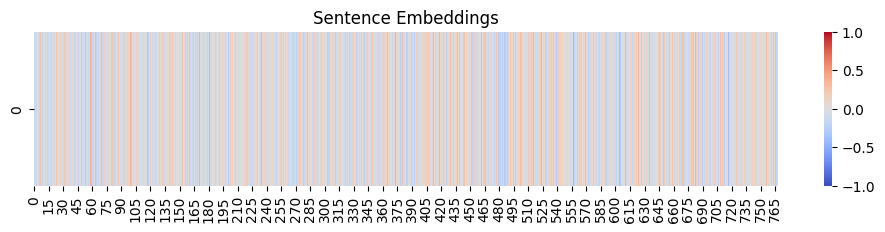

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(embedding1, embedding2, title):
    #calculate the difference between the two embeddings
    diff = embedding1 - embedding2
    #reshape the difference to a 2D array for the heatmap
    diff_2d = diff.reshape(1, -1)
    #create a heatmap
    plt.figure(figsize=(12, 2))
    sns.heatmap(diff, cmap='coolwarm', annot=False, cbar=True,vmin=-1,vmax=1)
    plt.title(title)
    plt.show()

#plot heatmap
#plot_heatmap(original_embedding, typo_embedding, "diff between embeddings")
plot_heatmap(sentence_embeddings[0],sentence_embeddings[1:],"Sentence Embeddings")

### with attention weights
from https://github.com/clarkkev/attention-analysis
- https://stackoverflow.com/questions/75772288/how-to-read-a-bert-attention-weight-matrix for explanation on queries and keys
- https://theaisummer.com/self-attention/#:%7E:text=Self%2Dattention%20is%20not%20symmetric!&text=The%20arrows%20that%20correspond%20to,Q%E2%80%8B%3DWK%E2%80%8B. explanation on self-attention
- heatmaps to analyze attention weights: https://apxml.com/courses/foundations-transformers-architecture/chapter-7-implementation-details-optimization/practice-analyzing-attention-weights
- excellent source: https://apxml.com/courses/how-to-build-a-large-language-model/chapter-23-analyzing-model-behavior/attention-map-visualization


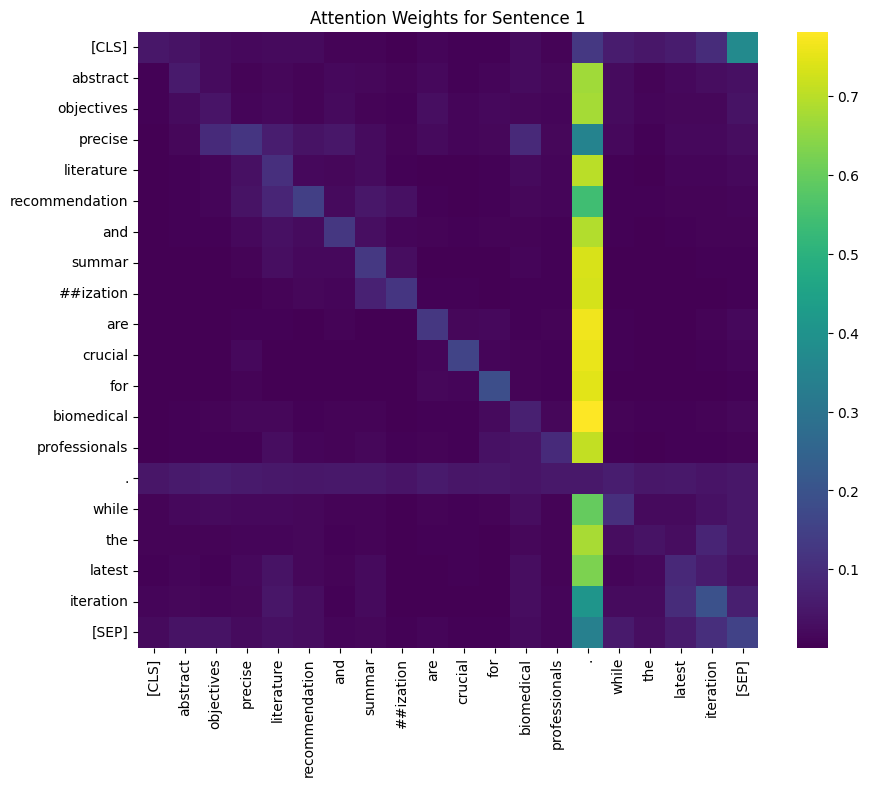

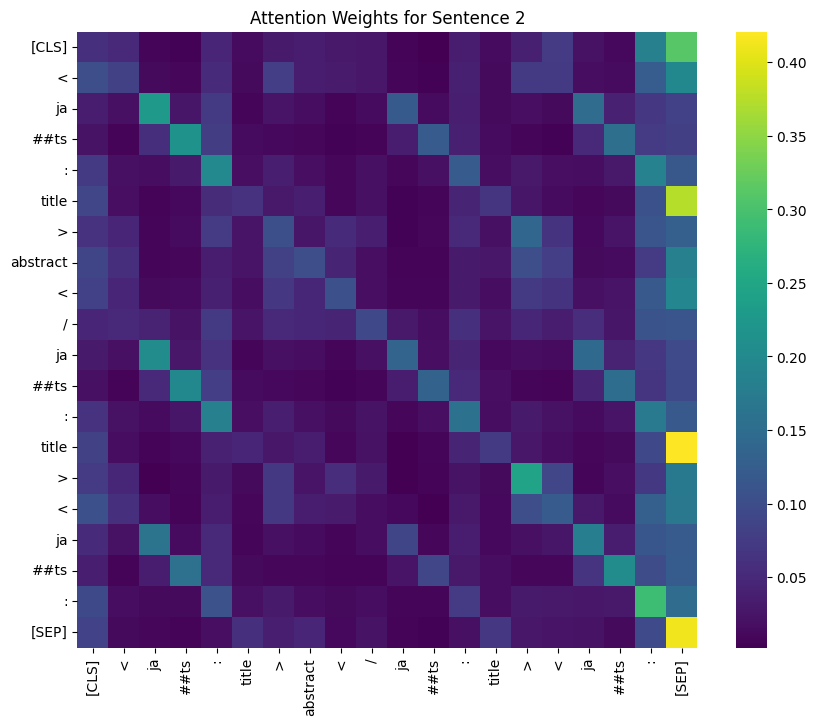

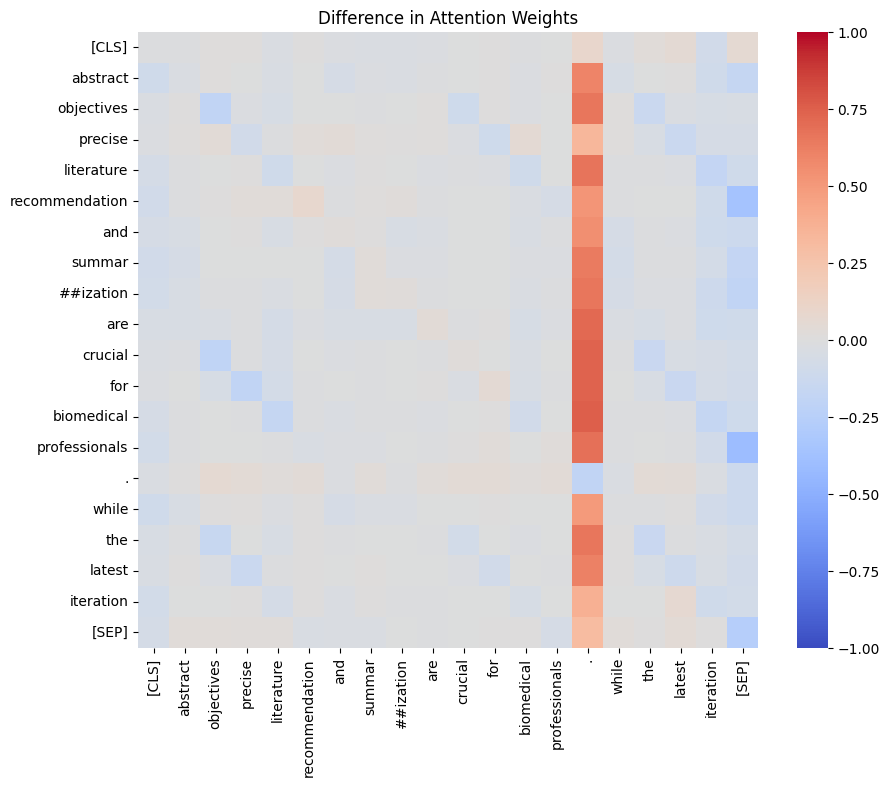

In [282]:
# same as above 
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load SciBERT tokenizer and model - same as above - technically don't need to relaod these unless changing
# try sentence based model?
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')


# Tokenize the sentences
inputs1 = tokenizer(original_text, return_tensors="pt", padding='max_length', truncation=True, max_length=20)#limit tokens so that we can actually see something
inputs2 = tokenizer(typo_text, return_tensors="pt", padding='max_length', truncation=True, max_length=20)#

# Get the attention weights: the `output_attentions=True` parameter is used to get the attention weights from the model
with torch.no_grad():
    outputs1 = model(**inputs1, output_attentions=True)
    outputs2 = model(**inputs2, output_attentions=True)

# Extract the attention weights for the last layer
#.squeeze() https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html
attention_weights1 = outputs1.attentions[-1].squeeze(0)  # Shape: (num_heads, seq_len, seq_len)
attention_weights2 = outputs2.attentions[-1].squeeze(0)  # Shape: (num_heads, seq_len, seq_len)

# Average the attention weights across all heads, 
#see last reference to visualize attention for each head
attention_weights1 = attention_weights1.mean(dim=0)  # Shape: (seq_len, seq_len)
attention_weights2 = attention_weights2.mean(dim=0)  # Shape: (seq_len, seq_len)

# Get the tokens for the sentences
tokens1 = tokenizer.convert_ids_to_tokens(inputs1["input_ids"].squeeze(0))
tokens2 = tokenizer.convert_ids_to_tokens(inputs2["input_ids"].squeeze(0))

# Plot the attention heatmap for the first sentence
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights1, xticklabels=tokens1, yticklabels=tokens1, cmap='viridis', annot=False, cbar=True)
plt.title("Attention Weights for original_text")
plt.show()

# Plot the attention heatmap for the second sentence
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights2, xticklabels=tokens2, yticklabels=tokens2, cmap='viridis', annot=False, cbar=True)
plt.title("Attention Weights for typo_text")
plt.show()

# Calculate the difference in attention weights
diff_attention_weights = (attention_weights1 - attention_weights2)

# Plot the **difference** in attention weights
plt.figure(figsize=(10, 8))
sns.heatmap(diff_attention_weights, xticklabels=tokens1, yticklabels=tokens1, cmap='coolwarm', annot=False, cbar=True, vmin=-1, vmax=1)
plt.title("Difference in Attention Weights")
plt.show()


## count specific terms in post-tokenized text
- [ ] identify which terms to look for. Is this from the query? Or characteristics to find? For example: counts of '<jats:p>' in the embedding?


## TF-IDF & cosine similarity
This would be used to see if any formatting characters ever show up in the top-n terms<br>
Look for local file /Users/poppyriddle/Documents/CODING_WORKING/Python/LIBRARIES/tfidf_cos_similarity/Tf_IDF_Cosign_similarity_heatmap_v11.ipynb
This has a simple approach for comparing and provides a heatmap